In [18]:
# Final project
student = 'Janne Arkko'
id = 'AB3817'
subject = 'Sentiment Analysis AI using LTSM algorithm'

# IMPORTS

In [34]:
# imports
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
from collections import Counter
from datetime import datetime

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Embedding, LSTM, Dense
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras import regularizers
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from kerastuner.tuners import Hyperband

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\janne\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\janne\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# LOADING DATA

All used data in this project are located in the data -folder in root of the project. Data folder is then split into 'train' and 'test' folders both holding the corresponding data for training and testing. Note: I did not use any testing data in this project.

In the code below,
1. Load the data from the data/train -folder that holds the cleaned and processed data ready to be used
2. Combine the data from 'data_paths' into a single dataframe with columns 'Text' and 'Sentiment'
3. Drop duplicated for the next phase and print the size of the dataframe

In [35]:
# loading data and removing stopwords

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

base_uri = './data/train/clean_train_texts/'
data_paths = [ # AllAgree source holds entries that all collaborators of the datasource agree in term of it's sentiment.
    #f'{base_uri}Sentences_AllAgree.txt',
    #f'{base_uri}Sentences_75Agree.txt', # each datasource can be commented out in modeling phase to reduce possible biasing and/or over/underfitting problems. 
    #f'{base_uri}Sentences_66Agree.txt',
    f'{base_uri}Sentences_50Agree_spacy.txt',
    f'{base_uri}twitter_training_clean_spacy.txt',
    f'{base_uri}twitter_training_2_clean_spacy.txt',
    f'{base_uri}airline-sentiment-clean-spacy.txt',
    ]

# empty dataframe
df = pd.DataFrame(columns=['Text', 'Sentiment'])

# Loop through each data source
for data_path in data_paths:
    texts = []
    sentiments = []

    # Open file and process lines
    with open(data_path, 'r', encoding='ISO-8859-1') as file:
        for line in file:
            if line.strip():  # Check if line is not empty
                text, sentiment = line.rsplit('@', 1)
                #clean_text = remove_stopwords(text.strip()) # apply remove_stopwords function to each text entry
                #texts.append(clean_text)
                texts.append(text)
                sentiments.append(sentiment.strip())
                
    # Create a temporary DataFrame for the current file
    temp_df = pd.DataFrame({
        'Text': texts,
        'Sentiment': sentiments
    })
    
    # Concatenate the temporary DataFrame with the main DataFrame
    df = pd.concat([df, temp_df], ignore_index=True)

# Check for duplicates
print(f"Original data size: {df.shape[0]}")
df = df.drop_duplicates()
print(f"Data size after removing duplicates: {df.shape[0]}")

df.head()


Original data size: 103903
Data size after removing duplicates: 94028


,Text,Sentiment
0,According to Gran the company has no plans to ...,neutral
1,Technopolis plans to develop in stages an area...,neutral
2,The international electronic industry company ...,negative
3,With the new production plant the company woul...,positive
4,According to the company updated strategy for ...,positive


# VISUALIZING ORIGINAL DATA

This phase consists of visualizing the data to get better understanding of value distribution, word counts and frequencies of specific words.

1. Distribution of Sentiments in a bar chart

Sentiment
negative    35079
neutral     32785
positive    26164
Name: count, dtype: int64


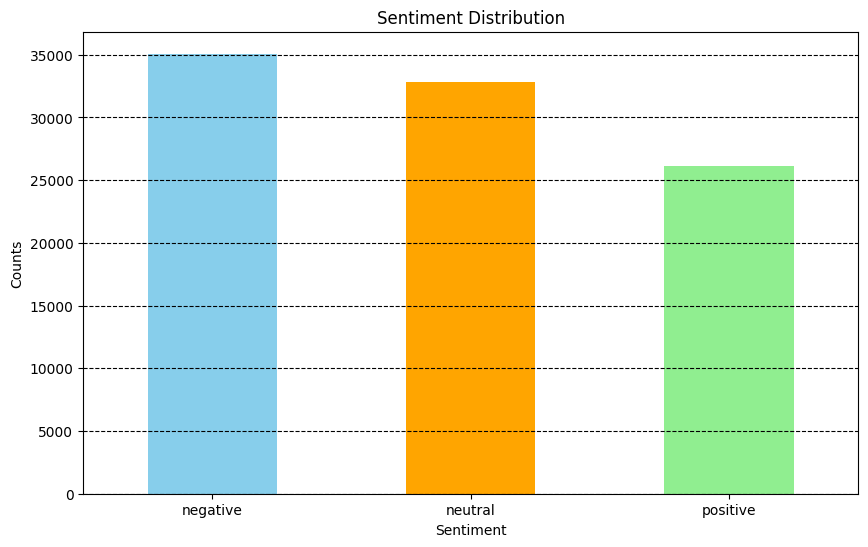

In [36]:
# visualizing original data
sentiment_counts = df['Sentiment'].value_counts()
print(sentiment_counts)

# bar chart for sentiment counts
plt.figure(figsize=(10, 6))
sentiment_counts.plot(kind='bar', color=['skyblue', 'orange', 'lightgreen'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', color='k')
plt.show()

2. Distribution of Sentiments in a pie chart

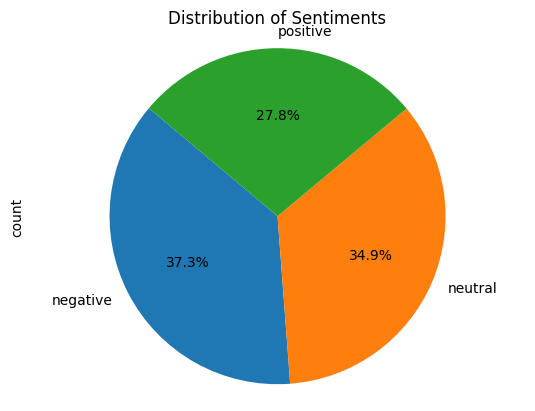

In [37]:
#pie chart for sentiment count %
df['Sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Distribution of Sentiments')
plt.show()

3. Cumulative distribution of word frequencies and frequencies of word in certain sentiment -category.

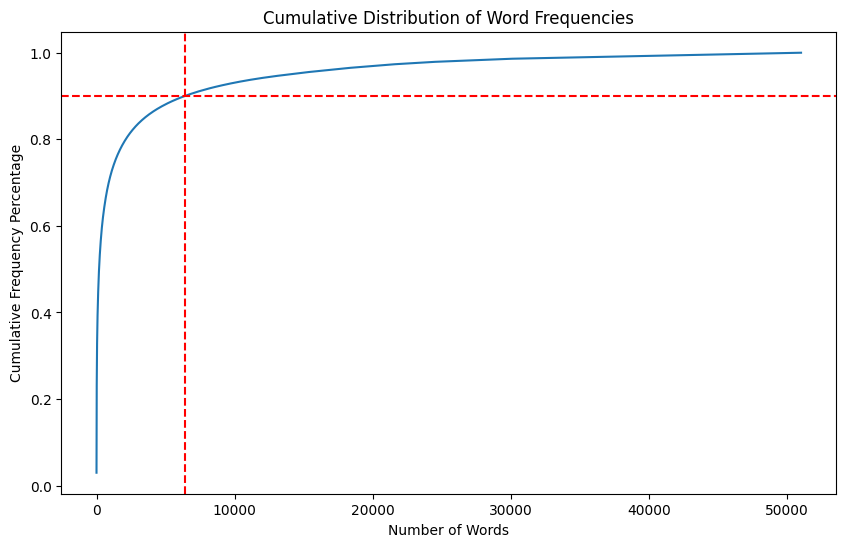

Number of words covering 90.0% of occurrences: 6391


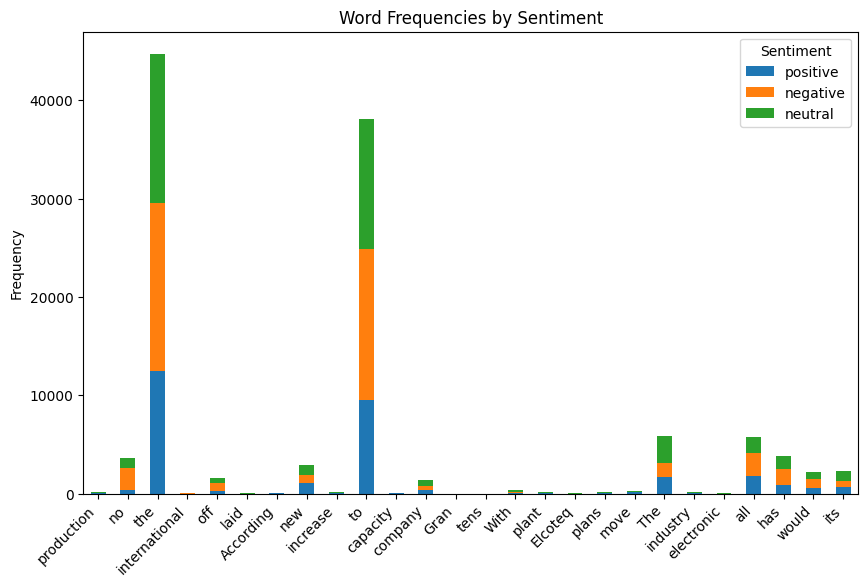

In [38]:
# word frequencies by each sentiment label

positive_text = ' '.join(df[df['Sentiment'] == 'positive']['Text'])
negative_text = ' '.join(df[df['Sentiment'] == 'negative']['Text'])
neutral_text = ' '.join(df[df['Sentiment'] == 'neutral']['Text'])

# frequencies for each word in sentiment labeled texts
word_frequencies = {
    'positive': Counter(positive_text.split()),
    'negative': Counter(negative_text.split()),
    'neutral': Counter(neutral_text.split())
}

# Combine counters from all sentiment categories
combined_frequencies = Counter()
for sentiment_counts in word_frequencies.values():
    combined_frequencies += sentiment_counts

# Sort words by frequency in descending order
sorted_word_freqs = sorted(combined_frequencies.items(), key=lambda x: x[1], reverse=True)

# Extract frequencies and compute the cumulative distribution
frequencies = np.array([freq for word, freq in sorted_word_freqs])
cumulative_frequencies = np.cumsum(frequencies)
total_words = cumulative_frequencies[-1]

# total occurence / cumulative frequencies
percentage_covered = cumulative_frequencies / total_words

# find how many words cover up to 90% of total occurrences
threshold = 0.90  # 90% threshold
num_words_90 = np.argmax(percentage_covered >= threshold) + 1

# plotting cumulative distribution
plt.figure(figsize=(10, 6))
plt.plot(percentage_covered)
plt.axhline(y=threshold, color='r', linestyle='--')
plt.axvline(x=num_words_90, color='r', linestyle='--')
plt.title('Cumulative Distribution of Word Frequencies')
plt.xlabel('Number of Words')
plt.ylabel('Cumulative Frequency Percentage')
plt.show()

print(f"Number of words covering {threshold*100}% of occurrences: {num_words_90}")

# common words
all_common_words = set(list(word_frequencies['positive'].keys())[:10]) | \
                   set(list(word_frequencies['negative'].keys())[:10]) | \
                   set(list(word_frequencies['neutral'].keys())[:10])

# Create a DataFrame for word frequencies by sentiment
frequencies_df = pd.DataFrame({
    sentiment: {word: word_frequencies[sentiment].get(word, 0) for word in all_common_words}
    for sentiment in ['positive', 'negative', 'neutral']
})

# Plotting
frequencies_df.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Word Frequencies by Sentiment')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.legend(title='Sentiment')
plt.show()

4. Word count histogram to acknowledge how much certain words does each sentiment-category hold.

Text(0, 0.5, 'Frequency')

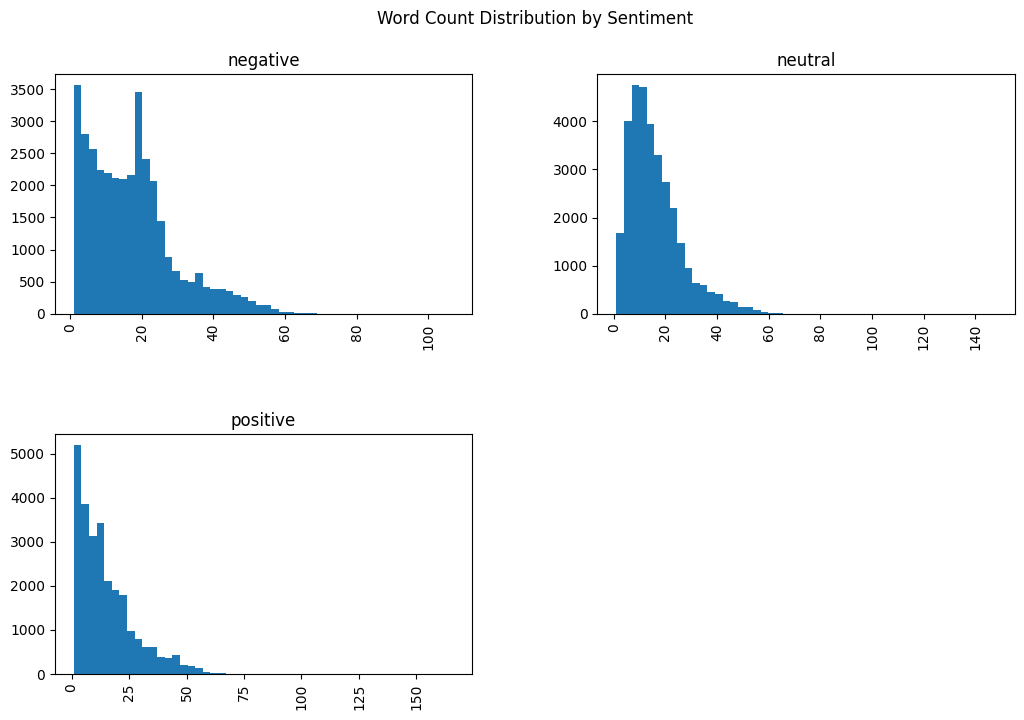

In [39]:
# word count histogram

df['Word Count'] = df['Text'].apply(lambda x: len(x.split()))
df.hist(column='Word Count', by='Sentiment', bins=50, figsize=(12, 8))
plt.suptitle('Word Count Distribution by Sentiment')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# PREPROCESSING

This phase consists of preprocessing the data for it to be suitable for the modeling phase.

1. Tokenization. I used the Tokenizer class in Keras preprocessing library to tokenize each 'text' string into sequences. The size of the tokenizer comes from the cumulative distribution of word frequencies so that the tokenizer is not fed with all the words but with words that cover 90% of the words in the data.
2. Determining the padding for the sequences. (Word are in different lengths so padding must be applied so that each text as input is same length)

Max length of all sequences: 166
90th percentile length: 30.0


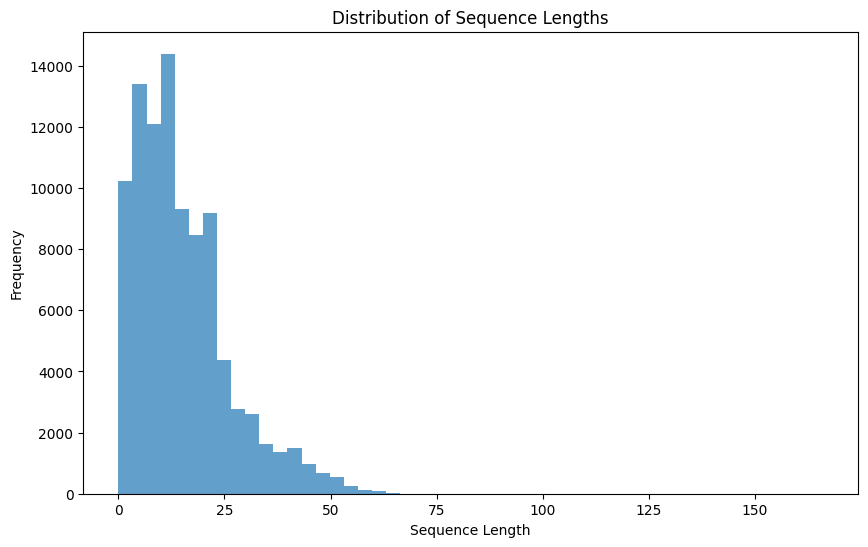

In [40]:
# tokenization
import pickle
tokenizer = Tokenizer(num_words=num_words_90) # this number comes from 90% coverance in word_frequencies
tokenizer.fit_on_texts(df['Text'])
sequences = tokenizer.texts_to_sequences(df['Text'])

datetime_str = datetime.now().strftime("%Y%m%d-%H%M%S")
filename = f'./model/tokenizer_pickles/tokenizer_{datetime_str}.pickle'

with open(filename, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# determining the maxlen property of pad_sequences
sequence_lengths = [len(sequence) for sequence in sequences]
lengths_df = pd.DataFrame(sequence_lengths, columns=['Lengths'])
max_length = max(len(sequence) for sequence in sequences)  # Get the length of the longest sequence
print(f'Max length of all sequences: {max_length}')

# calculating the 90th percentile of sequence lengths
max_length_90th_percentile = lengths_df['Lengths'].quantile(0.90)
print(f"90th percentile length: {max_length_90th_percentile}")

# plotting a histogram of sequence lengths
plt.figure(figsize=(10, 6))
plt.hist(lengths_df['Lengths'], bins=50, alpha=0.7)
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

# choosing on the 90th percentile length as maxlen-parameter for the padded sequences as it is probably the most deterministic.
padded_sequences = pad_sequences(sequences, maxlen=max_length_90th_percentile.astype(int), padding='post')

# MODELING

In this phase it's time to start modeling.

1. Encode the 'Sentiment' values into labels

In [41]:
# encoding labels

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df['Sentiment'])
categorical_labels = to_categorical(encoded_labels)

datetime_str = datetime.now().strftime("%Y%m%d-%H%M%S")
filename = f'./model/label_encoder_pickles/label_encoder_{datetime_str}.pickle'

with open(filename, 'wb') as file:
    pickle.dump(label_encoder, file, protocol=pickle.HIGHEST_PROTOCOL)

2. Split data into training and testing in 80%/20% ratio

In [42]:
# splitting training and testing data

X = padded_sequences
y = categorical_labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

3. (commented out) Use Hyperband -tuner to find best hyperparameters for the LSTM model with 2 LSTM layers, 2 dropout layers and 2 dense layers.

In [43]:
# Find best hyperparameters by using keras tuner

# scheduler
""" def scheduler(epoch, lr):
    if epoch < 2:
        return lr
    else:
        return lr * math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

vocab_size = len(tokenizer.word_index) + 1
input_max_length = max_length_90th_percentile.astype(int)
# I commented this out as it has ran once with over 2 hour runtime and has given the best hyperparameters for this dataset
def build_model(hp):
    model = Sequential([
        Embedding(input_dim=vocab_size, 
                  output_dim=hp.Int('embedding_dim', min_value=32, max_value=128, step=16), 
                  input_length=input_max_length),
        LSTM(units=hp.Int('lstm_units_1', min_value=32, max_value=128, step=32), return_sequences=True),
        Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)),
        LSTM(units=hp.Int('lstm_units_2', min_value=16, max_value=64, step=16), return_sequences=False),
        Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.3, step=0.1)),
        Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=32), 
              activation='relu', 
              kernel_regularizer=regularizers.l2(0.01)),
        Dense(units=categorical_labels.shape[1], activation='softmax')
    ])
    
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

# tuner, using Hyperband with val_acc objective
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    directory='./model/tuner/trials',
    project_name='keras_tuner_trials'
)

tuner.search(X_train, y_train, epochs=50, validation_split=0.3, callbacks=[early_stopping, lr_scheduler])

best_model = tuner.get_best_models(num_models=1)[0]
best_model.save('./model/tuner/best_model.h5')

loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%") """


Trial 30 Complete [00h 07m 38s]
val_accuracy: 0.7573891282081604

Best val_accuracy So Far: 0.76399165391922
Total elapsed time: 02h 35m 26s


c:\Users\janne\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


588/588 [==============================] - 5s 7ms/step - loss: 0.7638 - accuracy: 0.7606
Test Accuracy: 76.06%


4. Build the model with the best hyperparameters. 

In [29]:
# building the model with the best hyperparameters
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 112
input_max_length = max_length_90th_percentile.astype(int)

model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=input_max_length),
    LSTM(units=128, return_sequences=True),
    Dropout(0.3),
    LSTM(units=32),
    Dropout(0.2),
    Dense(units=128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(units=categorical_labels.shape[1], activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 30, 112)           4378864   
                                                                 
 lstm_2 (LSTM)               (None, 30, 128)           123392    
                                                                 
 dropout_2 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                20608     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 128)               4224      
                                                                 
 dense_3 (Dense)             (None, 3)                

5. In this training phase, a scheduler is used to lower the learning rate after 'n' epochs, a checkpoint to store best model in root and early stopping to prevent overfitting.

In [50]:
# callbacks

# scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

# checkpoint, always save best model to root
model_checkpoint = ModelCheckpoint(
    './model/best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    model='min',
    verbose=1
)

# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
best_model_from_file = load_model('./model/tuner/best_model.h5') # load the best model
# Training the model
#best_model.fit(X_train, y_train, epochs=20, validation_split=0.3, callbacks=[early_stopping, lr_scheduler, model_checkpoint])
history = best_model_from_file.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[lr_scheduler, model_checkpoint])

Epoch 1/50
1880/1881 [============================>.] - ETA: 0s - loss: 0.3303 - accuracy: 0.8858
Epoch 1: val_loss improved from inf to 0.69622, saving model to ./model\best_model.h5
1881/1881 [==============================] - 97s 51ms/step - loss: 0.3302 - accuracy: 0.8858 - val_loss: 0.6962 - val_accuracy: 0.7720 - lr: 3.6788e-04
Epoch 2/50
   1/1881 [..............................] - ETA: 1:30 - loss: 0.2155 - accuracy: 0.9062

c:\Users\janne\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1881/1881 [==============================] - ETA: 0s - loss: 0.2570 - accuracy: 0.9140
Epoch 2: val_loss did not improve from 0.69622
1881/1881 [==============================] - 95s 50ms/step - loss: 0.2570 - accuracy: 0.9140 - val_loss: 0.7369 - val_accuracy: 0.7713 - lr: 3.6788e-04
Epoch 3/50
1880/1881 [============================>.] - ETA: 0s - loss: 0.2277 - accuracy: 0.9244
Epoch 3: val_loss did not improve from 0.69622
1881/1881 [==============================] - 95s 50ms/step - loss: 0.2277 - accuracy: 0.9244 - val_loss: 0.7979 - val_accuracy: 0.7678 - lr: 3.6788e-04
Epoch 4/50
1880/1881 [============================>.] - ETA: 0s - loss: 0.2072 - accuracy: 0.9307
Epoch 4: val_loss did not improve from 0.69622
1881/1881 [==============================] - 94s 50ms/step - loss: 0.2072 - accuracy: 0.9308 - val_loss: 0.8282 - val_accuracy: 0.7712 - lr: 3.6788e-04
Epoch 5/50
1881/1881 [==============================] - ETA: 0s - loss: 0.1910 - accuracy: 0.9368
Epoch 5: val_loss did 

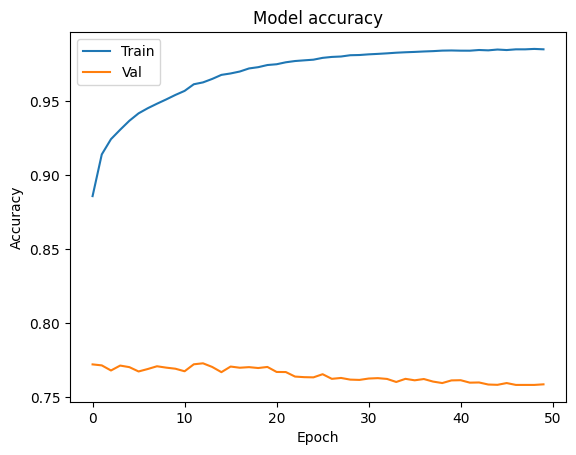

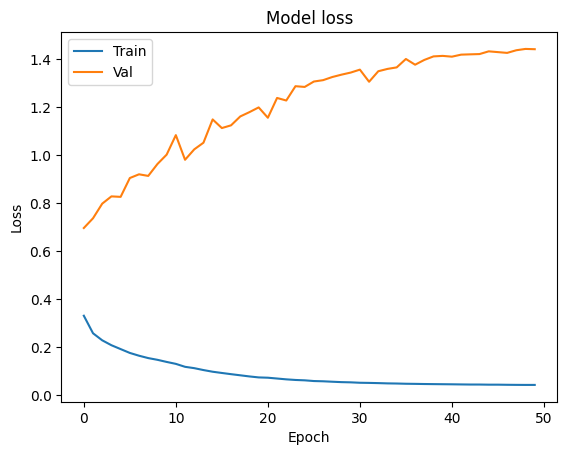

In [51]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

6. Load best model from root and evaluate with X_test and y_test

In [52]:
# Evaluation on the best model

loss, accuracy = best_model_from_file.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

588/588 [==============================] - 3s 6ms/step - loss: 1.4748 - accuracy: 0.7526
Test Accuracy: 75.26%


7. Predict X_test
8. Convert and map encoded labels back to actual labels
9. Convert tokenized sequences back to original text-strings 
10. Create a analysis -csv file to examine the results
11. Test the model with random news topics

In [53]:
# Predictions and testing

y_pred = best_model_from_file.predict(X_test) # make predictions on the best model

predicted_classes = np.argmax(y_pred, axis=1) # extract predicted one-hot encoded predicted classes
actual_classes = np.argmax(y_test, axis=1) # extract actual classes
label_mapping = list(label_encoder.classes_) # map the actual labels ie. 'negative', 'positive', 'neutral' from the encoder
print(label_mapping)

predicted_labels = [label_mapping[i] for i in predicted_classes]
actual_labels = [label_mapping[i] for i in actual_classes]

index_word = {index: word for word, index in tokenizer.word_index.items()} # get the original words from tokenizer

def decode_sequence(sequence): # get original strings
    return ' '.join([index_word.get(i, '') for i in sequence if i != 0])

X_test_string = [decode_sequence(seq) for seq in X_test]

df_analysis = pd.DataFrame({ # form a dataframe with actual text, actual label and predicted label
    'Text': X_test_string,
    'Actual Label': actual_labels,
    'Predicted Label': predicted_labels
})

df_analysis.to_csv('model_predictions_analysis.csv', index=False) # save result into csv

# classification report
print(classification_report(actual_labels, predicted_labels, target_names=label_mapping))

# apply some self-made testing on the model
def predict_sentiment(text, best_model):
    # Preprocess the text
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=input_max_length)
    # Predict
    prediction = best_model.predict(padded_sequence)
    # Decode the prediction
    sentiment = label_encoder.inverse_transform([np.argmax(prediction)])
    return sentiment[0]

print(predict_sentiment("kamala harris is set to meet top israeli war cabinet official", best_model_from_file))
print(predict_sentiment("forced to change: tech giants bow to global onslaught of rules", best_model_from_file))
print(predict_sentiment("how regulations fractured apple's app store", best_model_from_file))
print(predict_sentiment("kremlin seeks to suppress Aleksei Navalny's influence, in death as in life", best_model_from_file))
print(predict_sentiment("britain is facing a Measles outbreak after vaccination rates dipped for years", best_model_from_file))
print(predict_sentiment("russian strike's toll rises to 12 as Zelesky blames air defense delay", best_model_from_file))
print(predict_sentiment("it just got easier to visit a vanishing glacier. is that a good thing?", best_model_from_file))
print(predict_sentiment("biden unites with an unlikely ally to champion ukraine", best_model_from_file))


588/588 [==============================] - 4s 5ms/step
['negative', 'neutral', 'positive']
              precision    recall  f1-score   support

    negative       0.77      0.79      0.78      7016
     neutral       0.74      0.72      0.73      6557
    positive       0.74      0.74      0.74      5233

    accuracy                           0.75     18806
   macro avg       0.75      0.75      0.75     18806
weighted avg       0.75      0.75      0.75     18806

1/1 [==============================] - 0s 14ms/step
positive
1/1 [==============================] - 0s 13ms/step
neutral
1/1 [==============================] - 0s 15ms/step
positive
1/1 [==============================] - 0s 14ms/step
negative
1/1 [==============================] - 0s 14ms/step
negative
1/1 [==============================] - 0s 14ms/step
negative
1/1 [==============================] - 0s 14ms/step
neutral
1/1 [==============================] - 0s 14ms/step
negative


12. Plot confusion matrix with actual and predicted labels

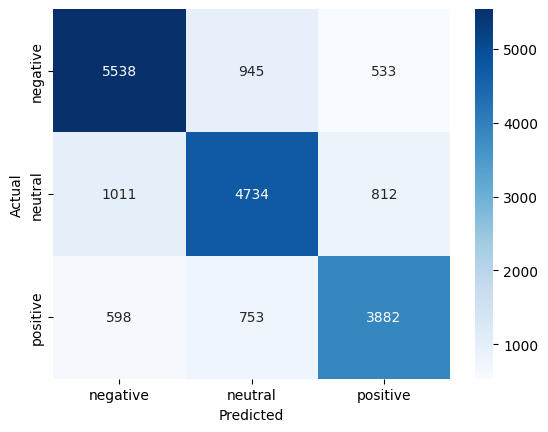

In [54]:
# plotting of results

#confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels, labels=label_mapping)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping, yticklabels=label_mapping)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


13. Error analysis

In [55]:
# Error analysis

# get incorrect predictions
incorrect_predictions_df = df_analysis[df_analysis['Actual Label'] != df_analysis['Predicted Label']]

# analyse common characteristics in incorrect predictions

incorrect_predictions_df = incorrect_predictions_df.copy()

# print the avg word length of each sentiment in incorrect predictions
incorrect_predictions_df.loc[:, 'Text Length'] = incorrect_predictions_df['Text'].apply(lambda x: len(x.split()))
print(incorrect_predictions_df.groupby('Actual Label')['Text Length'].mean()) 

# count common words in incorrect predictions
all_words_in_errors = ' '.join(incorrect_predictions_df['Text']).split()
word_counts = Counter(all_words_in_errors)
print(word_counts.most_common(20)) 

pd.crosstab(incorrect_predictions_df['Actual Label'], incorrect_predictions_df['Predicted Label'])


Actual Label
negative    13.146820
neutral     12.605595
positive    11.621021
Name: Text Length, dtype: float64
[('the', 2178), ('i', 1782), ('to', 1682), ('and', 1199), ('a', 1182), ('in', 935), ('of', 887), ('it', 811), ('is', 810), ('for', 756), ('you', 690), ('my', 662), ('on', 605), ('that', 537), ('this', 498), ('with', 433), ('be', 388), ('me', 384), ('have', 365), ('but', 364)]


Predicted Label,negative,neutral,positive
Actual Label,,,
negative,0,945,533
neutral,1011,0,812
positive,598,753,0


# Analysis of Results

Once I had chosen the topic, I started to research what models could be used in NLP tasks such as this and found out that the best could probably be the LSTM model.

Learning results were not as good as I had hoped, but the scope of this project was very large and there could've been alot to improve. The amount of data needed for this to work is massive and I kind of ran out of time. I had alot more data to be used some were not used.

Preprocessing of the data was tedious and the hardest part by far. Most of the data I collected were tweets collected from Twitter, which had alot of irregularities, bad grammar and most of all special marks and URL addresses that were in formats that caused alot of trouble to go through. The largest dataset was 'twitter_training.csv' with 80k+ lines of text. I was able to remove most of the noice and irrelevancies but still some remained. The quality of the data probably had the biggest impact on the model performance.

In data loading step I also tried different versions of data by removing stopwords (if, of, the, a, etc), I didn't find much impact on the performance by doing that. 

For modeling, I chose to go with the sequential LSTM algorithm. I did some research on what models could work with NLP tasks and LSTM was the most promising. I did not try any other models as I simply ran out of time and tried to make the LSTM model the most efficient as possible. I was not perfectly happy with the predictions overall as I am implementing this model to another course task so I wished it to be more accurate, but the sheer amount of work this needs to be effective is just enormous. It is definitely not an easy process to create a good performing NLP model. The overall accuracy of the model with test data was roughly 80-84%.

For future optimization, the data fed to the model has to be perfect or near-perfect. Finding the smallest of nuances and meanings is not a problem for the model if the data is high quality. In my case it wasn't, and that is, in my opinion, the greatest obstacle with the model. Refactoring hundreds of thousands of text lines to a correct format with good vocabulary and with no spelling mistakes is very long process that requires countless steps.

Even this topic was hard and the results were mediocre at most, I really enjoyed it and learned alot from it. The data is the cornerstone of this kind of project and it needs to be high quality or else it has no meaning. Overall a very fun project to work with and next step is to try to implement it into a software and continue optimizing the model and cleaning the data.a

# Citations

Malo, P., Sinha, A., Takala, P., Korhonen, P. and Wallenius, J. (2013): “Good debt or bad debt: Detecting semantic orientations in economic texts.” Journal of the American Society for Information Science and Technology. (in Press)